# Librerías

In [646]:
# Librerias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Carga de datos

In [647]:
# Cargo el archivo CSV en un DataFrame de Pandas
df = pd.read_csv('final_dataset.csv', parse_dates=['t'], index_col=['t']).drop(columns= ['Unnamed: 0', 'pc12'])
df.columns

Index(['symbol', 'o', 'h', 'l', 'c', 'v', 'n', 'vw', 'diff', 'emaS', 'emaM',
       'emaL', 'std', 'pc', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS',
       'rlmL', 'rlmD', 'obv', 'obvmS', 'obvmL', 'obvsL', 'obvSH', 'lavgv',
       'lavm', 'lavs', 'avgv', 'ewm_12', 'ewm_26', 'macd', 'signal',
       'macd_std', 'macds', 'financial_data_age', 'P/E', 'P/S', 'P/B',
       'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_day_sin', 'time_embed_day_cos',
       'time_embed_week_sin', 'time_embed_week_cos', 'time_embed_month_sin',
       'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta'],
      dtype='object')

# Análisis descriptivo básico y transformaciones

In [648]:
unique_symbols = df['symbol'].unique()
print(unique_symbols)

['BABA' 'AAPL' 'AMZN' 'META' 'MSFT' 'TSLA' 'BAC' 'GOOG' 'JPM' 'KO' 'PFE'
 'XOM' 'CVX' 'NVDA']


In [649]:
# Como test, inicio solo creando un modelo para Amazon
data = df[df['symbol'] == 'MSFT' ].drop(columns= ['symbol', 'spy_value'])

Considerando una estrategia de inversión diaria, en este caso de probará con datos agregados a nivel diario.

In [650]:
# Crear diccionario para entregar la información de agregación de cada columna
agg_dict = {col: 'mean' for col in data.columns}

agg_dict['o'] = 'last'
agg_dict['c'] = 'last'
agg_dict['h'] = 'last'
agg_dict['l'] = 'last'

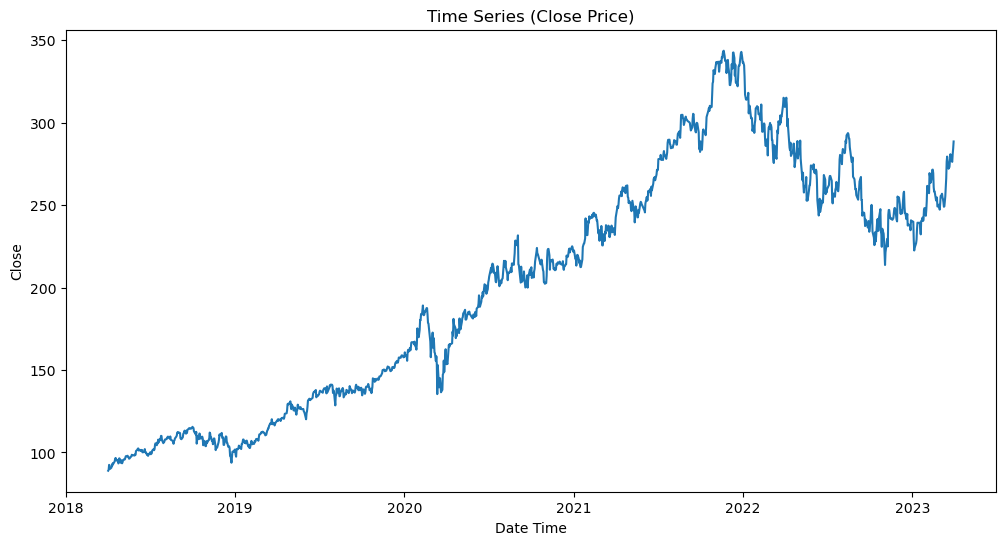

In [651]:
# Agregar a nivel diario y visualizar el close, que será la base para crear el target que despues se calculará como la diferencia % de close

df_daily = data.resample('D').agg(agg_dict)
df_daily = df_daily.dropna(how='all')

plt.figure(figsize=(12, 6))
plt.plot(df_daily['c'])
plt.xlabel('Date Time')
plt.ylabel('Close')
plt.title('Time Series (Close Price)')
plt.show()


Esta vez se crea una variable target que mide la suma de la variación % entre una dia cualquiera y el anterior . Se elige 5 dado que para hacer la predicciones se usará times series con una ventana de 5 días de variables explicativas y un target del siguiente día. Es un modelo de regresión.

In [652]:
# Se crea el target 
df_daily['prev_close1'] = df_daily['c'].shift(1)
df_daily['prev_close5'] = df_daily['c'].shift(5)

df_daily['close_diff1'] = (df_daily['c'] - df_daily['prev_close1']) /  df_daily['prev_close1'] *100
df_daily['close_diff5'] = (df_daily['c'] - df_daily['prev_close5']) /  df_daily['prev_close5'] *100
#df_daily['close_diff_15'] = ( df_daily['close_diff1'] + df_daily['close_diff5']) 
df_daily['close_diff_15'] = df_daily['close_diff1']

df_daily.drop(columns=['prev_close1'], inplace=True)
df_daily.drop(columns=['prev_close5'], inplace=True)
df_daily.drop(columns=['close_diff1'], inplace=True)
df_daily.drop(columns=['close_diff5'], inplace=True)



In [653]:
# Se revisa lo creado
df_daily[['c', 'close_diff_15']][0:10]

,c,close_diff_15
t,,
2018-04-02,88.95,NaN
2018-04-03,89.44,0.550871
2018-04-04,92.50,3.421288
2018-04-05,90.80,-1.837838
2018-04-06,90.05,-0.825991
2018-04-09,90.80,0.832871
2018-04-10,92.70,2.092511
2018-04-11,92.05,-0.701187
2018-04-12,93.48,1.553504


(array([  1.,   2.,  15., 119., 749., 416.,  42.,   5.,   2.,   1.]),
 array([-11.79153094,  -9.31252556,  -6.83352018,  -4.35451479,
         -1.87550941,   0.60349598,   3.08250136,   5.56150674,
          8.04051213,  10.51951751,  12.9985229 ]),
 <BarContainer object of 10 artists>)

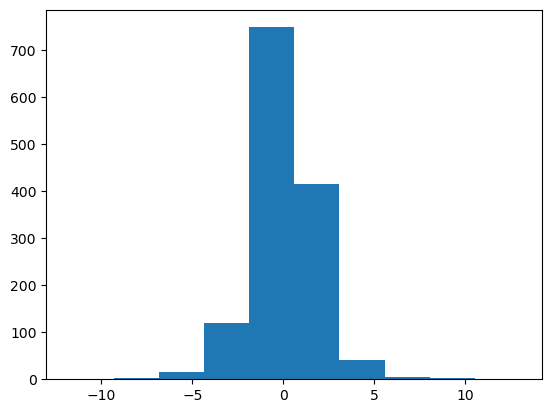

In [654]:
plt.hist(df_daily['close_diff_15'])

In [655]:
df_daily['close_diff_15'].std()


1.8143741957511836

In [656]:
df_daily['close_diff_15'].mean()

0.10351006758695296

In [657]:
df_daily['close_diff_15'].max()

12.99852289512555

In [658]:
df_daily['close_diff_15'].min()

-11.791530944625404

In [659]:
quartiles = pd.qcut(df_daily['close_diff_15'], 4)

# Count the frequency of each quartile using the value_counts() method
freq_per_quartile = quartiles.value_counts()

print(freq_per_quartile)

(-11.793, -0.75]    338
(-0.75, 0.0338]     338
(0.0338, 1.075]     338
(1.075, 12.999]     338
Name: close_diff_15, dtype: int64


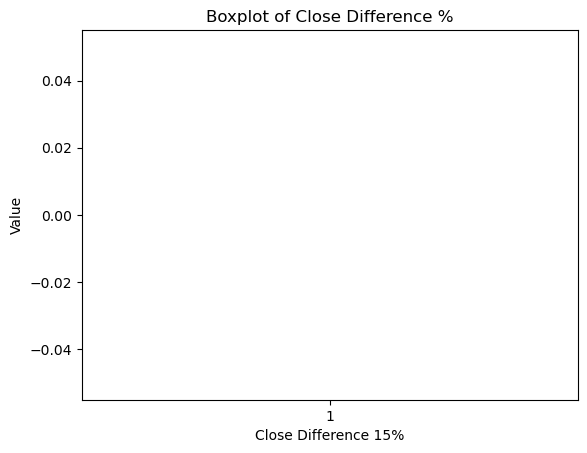

In [660]:

# Create a boxplot of the 'close_diff_15' column using Matplotlib
plt.boxplot(df_daily['close_diff_15'])

plt.title('Boxplot of Close Difference %')
plt.xlabel('Close Difference 15%')
plt.ylabel('Value')

plt.show()


In [661]:
# Revisar y eliminar filas en blanco (dado que se sabe que son pocas)
blank_rows = df_daily[df_daily.isnull().any(axis=1)]
blank_rows


,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta,close_diff_15
t,,,,,,,,,,,,,,,,,,,,,
2018-04-02,88.65,88.95,88.65,88.95,3.239910e+06,23002.266667,89.352464,0.998331,0.998610,0.999613,...,0.997423,0.999858,0.016544,0.684740,0.998461,0.998430,-0.026638,NaN,NaN,NaN
2018-04-03,89.54,89.59,89.41,89.44,2.304880e+06,15712.250000,89.227585,1.000464,1.000284,0.999744,...,0.964007,0.999994,-0.000359,0.945665,0.999466,1.000270,0.365374,NaN,NaN,0.550871
2018-04-04,92.46,92.55,92.33,92.50,2.218618e+06,14729.375000,90.003050,1.002070,1.001288,1.000061,...,0.888298,0.999840,-0.017572,0.952216,0.999934,1.000612,0.283329,NaN,NaN,3.421288
2018-04-05,91.56,91.56,90.63,90.80,1.851384e+06,12373.437500,92.374936,0.999031,1.000609,1.000544,...,0.773766,0.999390,-0.034780,0.982104,1.000485,1.000599,-0.303835,NaN,NaN,-1.837838
2018-04-06,90.05,90.05,90.05,90.05,2.304907e+06,14730.625000,91.043825,0.999332,0.999035,1.000045,...,0.625417,0.998643,-0.051978,0.978812,0.999979,0.999139,-0.174239,NaN,NaN,-0.825991


Eliminar filas en blancos (son pocas)

In [662]:
df_daily = df_daily.dropna() # Se eliminan días sin datos

Para ayudar al modelo se convierten necesarias a estacionarias (luego del test adfuller)

In [663]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    return result[1]  # Return the p-value

def test_columns(data, threshold=0.05):
    non_stationary_columns = {}
    non_stationary_columns_justcolumns = []
    for column in data.columns:
        p_value = adf_test(data[column])
        if p_value > threshold:
            non_stationary_columns[column] = p_value
            non_stationary_columns_justcolumns.append(column)

    return non_stationary_columns, non_stationary_columns_justcolumns



In [664]:
non_stationary_columns = test_columns(df_daily)

In [665]:
#Se imprimen las no estacionarias
print("Non-stationary columns with p-value > 0.05:")
for column, p_value in non_stationary_columns[0].items():
    print(f"{column}: {p_value}")

Non-stationary columns with p-value > 0.05:
o: 0.7213204149682388
h: 0.7200294428939644
l: 0.7210079793420108
c: 0.7206885395113715
vw: 0.7167965802057471
mnS: 0.11849818785151334
mnL: 0.27213668282086034
rlmS: 0.07822259411925342
rlmL: 0.20411259683600075
obv: 0.9622809147095817
obvmS: 0.9658736157507037
obvmL: 0.9526520455047758
lavgv: 0.7463504220042523
lavm: 0.7112787354819785
ewm_12: 0.7122641777064055
ewm_26: 0.7052210405285227
macd_std: 0.1321328236092223
P/E: 0.10285988809909813
P/S: 0.7764950765254496
P/B: 0.7167965802057471
ROE: 0.12071056344770248
ROA: 0.31189747525800493
Operating_Margin: 0.19987427795264417
Net_Profit_Margin: 0.10390925360598463
Current_Ratio: 0.4690903636757203
Debt_to_Equity: 0.49382208156028085
FCF: 0.09527846362822634


In [666]:
# Perform ADF test
result = adfuller(df_daily['close_diff_15'])

# Print results
print('ADF Statistic: {:.4f}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))

# Interpret p-value
alpha = 0.05  # Significance level
if result[1] < alpha:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")

ADF Statistic: -8.2591
p-value: 0.0000
Reject the null hypothesis (H0): The time series is stationary.


In [667]:
df_daily = df_daily.copy()


In [668]:
# En base a resultado anterior, se hacen estacionarias estos atributos en base a la diferenciación con dia anterior
for column in non_stationary_columns[1]:
     df_daily[f'{column}_diff'] = df_daily[column].diff()

In [669]:
for column in non_stationary_columns[1]:
     df_daily.drop(column, axis=1, inplace=True)


In [670]:
# Se revisan columnas que van quedando
df_daily.columns

Index(['v', 'n', 'diff', 'emaS', 'emaM', 'emaL', 'std', 'pc', 'mvS', 'mvL',
       'rsi', 'rsid', 'rlmD', 'obvsL', 'obvSH', 'lavs', 'avgv', 'macd',
       'signal', 'macds', 'financial_data_age', 'EPS_Growth', 'Gross_Margin',
       'time_embed_day_sin', 'time_embed_day_cos', 'time_embed_week_sin',
       'time_embed_week_cos', 'time_embed_month_sin', 'time_embed_month_cos',
       'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation',
       'market_long_term_trend', 'market_short_term_trend', 'market_change',
       'alpha', 'beta', 'close_diff_15', 'o_diff', 'h_diff', 'l_diff',
       'c_diff', 'vw_diff', 'mnS_diff', 'mnL_diff', 'rlmS_diff', 'rlmL_diff',
       'obv_diff', 'obvmS_diff', 'obvmL_diff', 'lavgv_diff', 'lavm_diff',
       'ewm_12_diff', 'ewm_26_diff', 'macd_std_diff', 'P/E_diff', 'P/S_diff',
       'P/B_diff', 'ROE_diff', 'ROA_diff', 'Operating_Margin_diff',
       'Net_Profit_Margin_diff', 'Current_Ratio_diff', 'Debt_to_Equity_diff',
       'FCF_diff'],
   

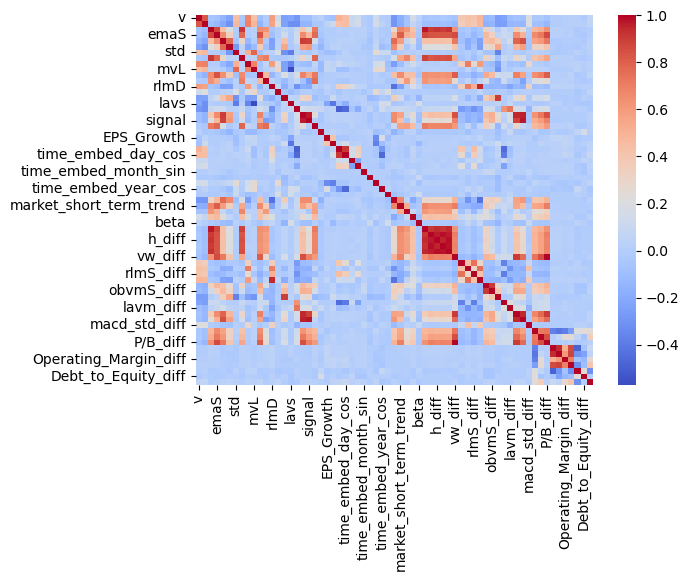

In [671]:
# Matriz correlacion (si bien se espera algunas correlaciones, si son pocas se probará directamente como esta el modelo)
corr_matrix = df_daily.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

plt.show()

In [672]:
# Se hace una copia del dataset y se eliminan los blancos si es que quedan
df_daily_final = df_daily.dropna() # .drop('c', axis=1)

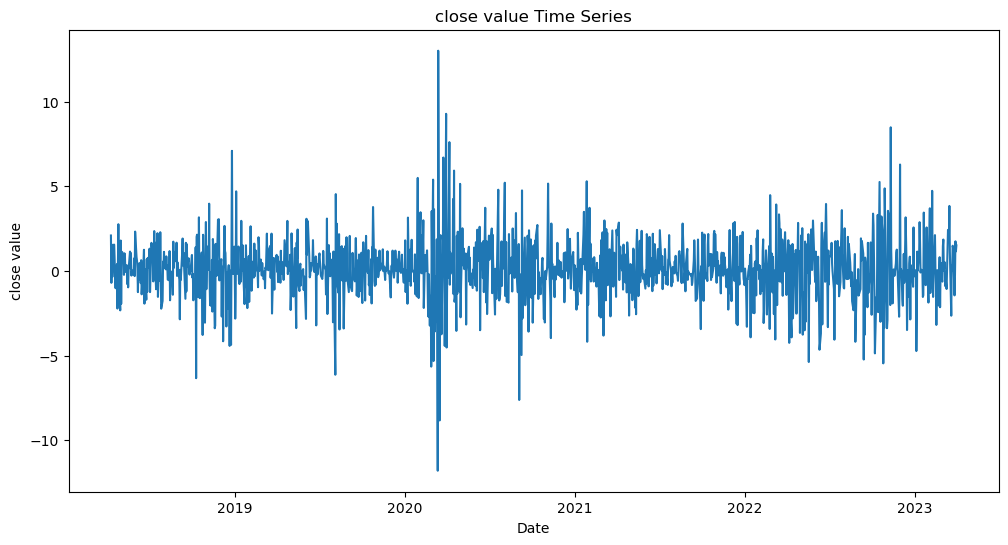

In [673]:
# Revisando la variable target
timeseries2 = df_daily_final['close_diff_15']
column = 'close value'
#close_diff_15
plt.figure(figsize=(12, 6))
plt.plot(timeseries2)
#plt.plot(timeseries2)
plt.title(f'{column} Time Series')
plt.xlabel('Date')
plt.ylabel(column)
plt.show()

Estandarizar datos

Se estandarizan los datos para evitar dar mas peso a unos atributos que otros. 

In [674]:

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(data)
# df_scaled_df = pd.DataFrame(df_scaled, columns=data.columns)

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_daily_final)
df_scaled_df = pd.DataFrame(df_scaled, columns=df_daily_final.columns, index=df_daily_final.index)
df_scaled_df

,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/E_diff,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff
t,,,,,,,,,,,,,,,,,,,,,
2018-04-10,0.229767,0.145416,0.577730,0.653721,0.684527,0.617053,0.499887,0.657522,0.294854,0.346255,...,0.690951,0.590965,0.523365,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-11,0.210910,0.128822,0.465061,0.526947,0.627206,0.598231,0.485129,0.509901,0.259805,0.321829,...,0.657044,0.568957,0.469931,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-12,0.244954,0.133353,0.557734,0.650331,0.680238,0.637158,0.473090,0.633802,0.309415,0.307731,...,0.689117,0.589774,0.520474,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-13,0.212752,0.129477,0.481566,0.549077,0.656621,0.638421,0.460554,0.525874,0.351992,0.306522,...,0.669880,0.577289,0.490159,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2018-04-16,0.185257,0.111101,0.555414,0.631285,0.682256,0.662159,0.445595,0.632154,0.315067,0.293261,...,0.682470,0.585460,0.510000,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.229583,0.245349,0.433427,0.508779,0.646239,0.772083,0.451040,0.435681,0.506087,0.611413,...,0.665430,0.574534,0.483392,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2023-03-28,0.187111,0.209882,0.484309,0.508110,0.549349,0.700652,0.439161,0.520930,0.411846,0.592221,...,0.626826,0.501641,0.334824,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475
2023-03-29,0.214314,0.227704,0.565288,0.673756,0.665590,0.755606,0.425483,0.637293,0.429971,0.571543,...,0.712940,0.664245,0.666235,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475


In [675]:
# Perform ADF test
result = adfuller(df_scaled_df['close_diff_15'])

# Print results
print('ADF Statistic: {:.4f}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))

# Interpret p-value
alpha = 0.05  # Significance level
if result[1] < alpha:
    print("Reject the null hypothesis (H0): The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0): The time series is non-stationary.")

ADF Statistic: -8.2654
p-value: 0.0000
Reject the null hypothesis (H0): The time series is stationary.


Creación de dataset para entrenamiento, validación y test

In [676]:
df_daily_final.shape

(1347, 65)

# Creación de dataset de Train y Validation

In [677]:
# Se separan los datos en train y  validacion (70 y 30%)
num_train_samples = int(0.7 * len(df_daily_final))
num_val_samples =  len(df_daily_final) -num_train_samples #int(0.3 * len(df_daily_final))
#num_test_samples = len(df_daily_final) - num_train_samples - num_val_samples
print("Número de train_samples:", num_train_samples)
print("Número de val_samples:", num_val_samples)
#print("Número de test_samples:", num_test_samples)

Número de train_samples: 942
Número de val_samples: 405


In [678]:
# Check de donde queda el corte para validación
timestamp_at_num_train_samples = df_daily_final.index[num_train_samples]
timestamp_at_num_train_samples

Timestamp('2021-10-13 00:00:00')

In [679]:
# Se inicia lo necesario para crear las secuencias para el modelo. Iré con secuencias de 5 dias tomando todas las variables y el target será solo el close.
days_to_predict = 1
target_column_index = df_daily_final.columns.get_loc('close_diff_15') # Columna target
sampling_rate = 1 #Dado que los datos ya estan resumidos por día, se va tomando fila a fila sin saltos
sequence_length = 5 # 5 (5 días anteriores a tomar en cuenta).
delay = sampling_rate * (sequence_length ) #Comienzo del target
batch_size = 10 #La cantidad de batch que creará, cada una con X (samples) e y (target)

In [680]:
df_scaled[:-delay ].shape[0]

1342

In [681]:
df_scaled.shape

(1347, 65)

In [682]:
# Finalmente se hace la separación

#targets = np.array([df_scaled[i:i+days_to_predict, target_column_index] for i in range(len(df_scaled) - delay)]) #nultiple output
#targets = np.array([df_scaled[i+sequence_length:i+delay+1, target_column_index] for i in range(len(df_scaled) - delay)]) #1 output

# Create datasets for the model
train_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  df_scaled[:, target_column_index][delay:] ,       #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled[:-delay ],
    targets=  df_scaled[:, target_column_index][delay:]  ,      #targets[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=df_scaled[:-delay ].shape[0]-1)

# test_dataset = keras.utils.timeseries_dataset_from_array(
#     df_scaled[:-delay ],
#     targets=targets[delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=num_train_samples + num_val_samples)

In [683]:
# Se revisan resultados de separacion
for x_batch, y_batch in train_dataset:
    print("x_batch shape:", x_batch.shape)
    print("x_batch values:\n", x_batch)
    print("y_batch shape:", y_batch.shape)
    print("y_batch values:\n", y_batch)
    break

x_batch shape: (10, 5, 65)
x_batch values:
 tf.Tensor(
[[[2.56133142e-01 1.19416586e-01 5.52283454e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [3.24097548e-01 1.48538198e-01 4.74746414e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.23558390e-01 1.30237366e-01 5.04878804e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.51490149e-01 1.38056914e-01 5.78920848e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.78033054e-01 1.58717736e-01 3.97843239e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]]

 [[3.44657239e-01 2.35142386e-01 5.38865324e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.59344922e-01 1.79256902e-01 4.71030887e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [3.60218697e-01 2.42524691e-01 2.55148750e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.55167577e-01 1.74100657e-01 6.60371496e-01 ... 6.03201217e-01
   1.00000000e+00 5.12474943e-01]
  [2.62097521e-01 1.76028931e-01 5

In [684]:
# Se siguen revisando resultados de separacion
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (10, 5, 65)
targets shape: (10,)


Ejemplo de los datos que estaremos pasando al modelo (por cada ejemplo, 54 valores de todas las columnas de 7 dias completos y como target el valor del dia siguiente)

In [685]:
# Se siguen revisando resultados de separacion
print("Inputs para primer sample:", samples.numpy()[1]) 
print("Targets para primer sample :", targets[1])

Inputs para primer sample: [[0.1784959  0.19762208 0.53124972 0.60026086 0.61233046 0.72604592
  0.2823947  0.60170452 0.25620305 0.26569044 0.58443967 0.58861916
  0.41093636 0.40089281 0.58030777 0.36125755 0.26585785 0.54660156
  0.52519711 0.63916703 0.23613636 0.81438845 0.8274753  0.83445301
  0.76075494 0.93993309 0.71414734 0.94628122 0.72537348 0.97343586
  0.33919482 0.93442011 0.66300554 0.62628537 0.35050661 0.59399793
  0.56435877 0.51552542 0.5521049  0.55630936 0.53274829 0.55555556
  0.52349778 0.51441786 0.3848412  0.48434954 0.39170076 0.50672343
  0.58413987 0.67265007 0.44752634 0.3297688  0.52417099 0.52379839
  0.15038023 0.67735498 0.59283465 0.52349778 0.43910474 0.3812844
  0.34196843 0.4856746  0.60320122 1.         0.51247494]
 [0.21827277 0.2680316  0.44740945 0.51942433 0.59239137 0.70750987
  0.27440692 0.42610981 0.34328814 0.26069752 0.48877456 0.38108731
  0.47434523 0.37962216 0.58324338 0.326768   0.29573369 0.55399083
  0.56796465 0.42999082 0.247045

# Creación de modelo

Combina capa convolucional para extraer idealmente patrones iniciales de menor dimensionalidad en los datos y luego una LSTM para predicción final y teniendo en cuenta el orden temporal. En este caso el modelo es regresión y predicirá el % de veriación (según el target creado y explicado anteriormente)


In [686]:
sequence_length

5

In [687]:
df_scaled.shape[-1]

65

Se crea modelo mencionado

In [688]:
#Modelo

# Parámetros
epochs = 100
batch_size = 10
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = layers.LSTM(256, recurrent_dropout=0.1, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(64, recurrent_dropout=0.1)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)



In [689]:
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
#alternativa probada: optimizer="rmsprop"

In [690]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5, 65)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 3, 128)            25088     
                                                                 
 lstm_18 (LSTM)              (None, 3, 256)            394240    
                                                                 
 dropout_9 (Dropout)         (None, 3, 256)            0         
                                                                 
 lstm_19 (LSTM)              (None, 64)                82176     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 501,569
Trainable params: 501,569
Non-trainab

In [691]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    verbose=0)


# Resultados del modelo

In [692]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


MAE

In [693]:
mae = history.history["mae"]
len(mae)

100

In [694]:
val_mae = history.history["val_mae"]
len(val_mae)

100

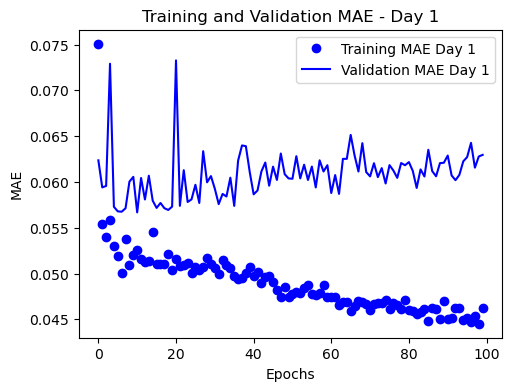

In [695]:
mae = history.history["mae"]
val_mae = history.history["val_mae"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot( mae, "bo", label="Training MAE Day 1")
plt.plot(val_mae, "b", label="Validation MAE Day 1")
plt.title("Training and Validation MAE - Day 1")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()



plt.show()


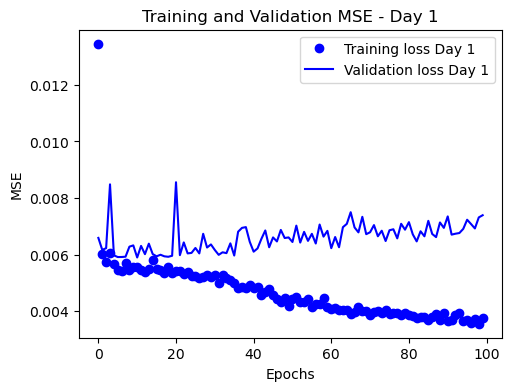

In [696]:
loss = history.history["loss"]
loss_mae = history.history["val_loss"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot( loss, "bo", label="Training loss Day 1")
plt.plot(loss_mae, "b", label="Validation loss Day 1")
plt.title("Training and Validation MSE - Day 1")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()



plt.show()

# Predicciones

Pequeña prueba de solo un ejemplo

In [697]:
sequence_length

5

In [698]:
df_scaled.shape[-1]

65

In [699]:
# Test Predict

# Selecciono una secuencia de ejemplo
inicio = 76
primer_ejemplo = df_scaled[inicio : sequence_length+inicio]

# Ajuste shape para que coincida con la entrada esperada por el modelo
primer_ejemplo_reshaped = np.reshape(primer_ejemplo, (1, sequence_length, df_scaled.shape[-1]))

# Hago la predicción usando el modelo
testprediccion = model.predict(primer_ejemplo_reshaped)

print(testprediccion)


1/1 [==============================] - 0s 193ms/step
[[0.46761248]]


Predicciones, métricas de evaluaciópn y gráficas finales

In [700]:
val_input_sequences = []
val_targets = []

for batch in val_dataset:
    inputs, targets = batch
    val_input_sequences.append(inputs.numpy())
    val_targets.append(targets.numpy())

# Concatenate the sequences and targets along the batch dimension
val_input_sequences = np.concatenate(val_input_sequences, axis=0)
val_targets = np.concatenate(val_targets, axis=0)


In [701]:
val_predictions = model.predict(val_input_sequences)

13/13 [==============================] - 0s 3ms/step


In [702]:
# Valores para hacer la inversa de escale en target y predicciones
C_index = df_daily_final.columns.get_loc('close_diff_15')
C_min = scaler.data_min_[C_index]
C_range = scaler.data_range_[C_index]


Ahora se lleva a la escala real

In [703]:
target_scaling_factor = scaler.scale_[target_column_index]
target_column_index = df_daily_final.columns.get_loc('close_diff_15')
target_scaling_factor = scaler.scale_[target_column_index]
original_mae = mae / target_scaling_factor
print("Original Mean Absolute Error:", original_mae)

Original Mean Absolute Error: [1.86158909 1.37275769 1.33714203 1.38485944 1.31466419 1.28816293
 1.24210209 1.33327052 1.26250492 1.28911894 1.30376031 1.27996667
 1.27175037 1.27319602 1.35143109 1.26556715 1.26595623 1.26577189
 1.29189036 1.24960877 1.28016217 1.2603852  1.26279028 1.26939165
 1.24014445 1.25703252 1.24869986 1.2584247  1.28158436 1.26629404
 1.2549842  1.23912214 1.27569353 1.26183427 1.25407132 1.23415711
 1.22395132 1.22640829 1.2408586  1.25602203 1.23306637 1.24425459
 1.21444091 1.2303352  1.23389373 1.21636494 1.19460059 1.17719674
 1.20205334 1.17654863 1.18361997 1.19022107 1.18742831 1.20087883
 1.20934817 1.18334108 1.18094607 1.18706962 1.2072581  1.17602233
 1.17495864 1.17619031 1.1540429  1.16285735 1.16359514 1.13883736
 1.15228732 1.16651349 1.1621614  1.15709433 1.14128981 1.15578758
 1.16111323 1.16096251 1.16664158 1.14385077 1.16057381 1.15499808
 1.14365379 1.16665848 1.14137421 1.13694104 1.13126538 1.1356619
 1.14372369 1.11180721 1.14640425

In [704]:
val_targets_escalareal=  val_targets * C_range + C_min
val_predictions_escalareal = val_predictions* C_range + C_min
mae_val_real = mean_absolute_error(val_targets_escalareal, val_predictions_escalareal)
print("Original Mean Absolute Error Escala Real:", original_mae)

Original Mean Absolute Error Escala Real: [1.86158909 1.37275769 1.33714203 1.38485944 1.31466419 1.28816293
 1.24210209 1.33327052 1.26250492 1.28911894 1.30376031 1.27996667
 1.27175037 1.27319602 1.35143109 1.26556715 1.26595623 1.26577189
 1.29189036 1.24960877 1.28016217 1.2603852  1.26279028 1.26939165
 1.24014445 1.25703252 1.24869986 1.2584247  1.28158436 1.26629404
 1.2549842  1.23912214 1.27569353 1.26183427 1.25407132 1.23415711
 1.22395132 1.22640829 1.2408586  1.25602203 1.23306637 1.24425459
 1.21444091 1.2303352  1.23389373 1.21636494 1.19460059 1.17719674
 1.20205334 1.17654863 1.18361997 1.19022107 1.18742831 1.20087883
 1.20934817 1.18334108 1.18094607 1.18706962 1.2072581  1.17602233
 1.17495864 1.17619031 1.1540429  1.16285735 1.16359514 1.13883736
 1.15228732 1.16651349 1.1621614  1.15709433 1.14128981 1.15578758
 1.16111323 1.16096251 1.16664158 1.14385077 1.16057381 1.15499808
 1.14365379 1.16665848 1.14137421 1.13694104 1.13126538 1.1356619
 1.14372369 1.1118072

In [705]:
# Convert numpy arrays to pandas Series
val_targets_escalareal = pd.Series(val_targets_escalareal.ravel(), name='val_targets_escalareal')
val_predictions_escalareal = pd.Series(val_predictions_escalareal.ravel(), name='val_predictions_escalareal')

# Concatenate the two Series to form a DataFrame
df_val = pd.concat([val_targets_escalareal, val_predictions_escalareal], axis=1)

# Calculate sign column
#df_val['sign'] = np.where(np.sign(df['val_targets_escalareal']) == np.sign(df['val_predictions_escalareal']), 1, 0)

df_val['sign'] = np.where(np.sign(df_val['val_targets_escalareal']) == np.sign(df_val['val_predictions_escalareal']), 1, 0)

df_val





,val_targets_escalareal,val_predictions_escalareal,sign
0,-0.473186,-0.046392,1
1,0.066642,-0.193073,0
2,1.660625,0.220422,1
3,-2.140652,-0.520391,1
4,2.190525,-0.193073,0
...,...,...,...
390,0.017778,-0.663690,0
391,-0.563527,-0.193073,1
392,0.168285,-0.335504,0
393,1.659672,-0.193073,0


Gráfico para comparar predicciones y reales en validación

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


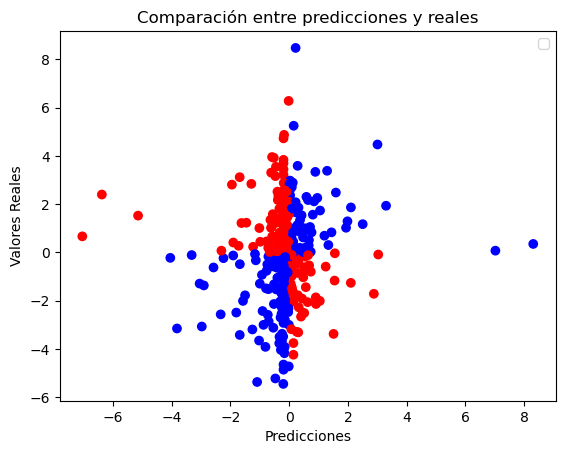

In [706]:
# Scatter plot with colored points based on sign column
colors = np.where(df_val['sign'] == 1, 'blue', 'red')
plt.scatter( df_val['val_predictions_escalareal'],df_val['val_targets_escalareal'],   c=colors)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Comparación entre predicciones y reales')
plt.legend()
plt.show()

Algunas métricas

In [707]:
r2 = r2_score(val_targets_escalareal, val_predictions_escalareal)
print("R-squared value:", r2)

mae = mean_absolute_error(val_targets_escalareal, val_predictions_escalareal)
print(f"Mean absolute error: {mae}")

mse = mean_squared_error(val_targets_escalareal, val_predictions_escalareal)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

R-squared value: -0.2551185156532223
Mean absolute error: 1.560822741106796
Mean Squared Error: 4.54223003377351
Root Mean Squared Error: 2.1312508143748614


Ahora se agrega el modelo para crear un dataset con todos los datos y todas las predicciones y ver el modelo en general


Función para predecir tomar el dataset completo y entregar las predicciones

In [708]:
def predict_close(df_scaled, sequence_length, model):
    num_samples =  len(df_scaled) - sequence_length
    dataiteration_list = []
    for i in range(num_samples):
        dataiteration = df_scaled[i : i + sequence_length]
        dataiteration = np.reshape(dataiteration , (1, sequence_length, df_scaled.shape[-1]))
        #Append the dataiteration result to the list
        dataiteration_list.append(dataiteration)

    
    # Convert the list to a numpy array and concatenate along the first axis
    dataiterations_array = np.concatenate(dataiteration_list, axis=0)
    
    predictions = model.predict(dataiterations_array)
    
    return predictions

In [709]:
predictions = predict_close(df_scaled, sequence_length, model)

42/42 [==============================] - 0s 3ms/step


In [710]:
df_scaled.shape

(1347, 65)

In [711]:
len(predictions)

1342

In [712]:
# Data escalda convertida a dataframe y agregando las predicciones segun el dia correspondiente
df_scaled_Predicciones = pd.DataFrame(df_scaled, columns=df_daily_final.columns, index=df_daily_final.index)

df_scaled_Predicciones['predictions'] = np.nan


df_scaled_Predicciones.loc[df_scaled_Predicciones.index[sequence_length:], 'predictions'] = predictions


df_scaled_Predicciones[0:10]


,v,n,diff,emaS,emaM,emaL,std,pc,mvS,mvL,...,P/S_diff,P/B_diff,ROE_diff,ROA_diff,Operating_Margin_diff,Net_Profit_Margin_diff,Current_Ratio_diff,Debt_to_Equity_diff,FCF_diff,predictions
t,,,,,,,,,,,,,,,,,,,,,
2018-04-10,0.229767,0.145416,0.577730,0.653721,0.684527,0.617053,0.499887,0.657522,0.294854,0.346255,...,0.590965,0.523365,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-11,0.210910,0.128822,0.465061,0.526947,0.627206,0.598231,0.485129,0.509901,0.259805,0.321829,...,0.568957,0.469931,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-12,0.244954,0.133353,0.557734,0.650331,0.680238,0.637158,0.473090,0.633802,0.309415,0.307731,...,0.589774,0.520474,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-13,0.212752,0.129477,0.481566,0.549077,0.656621,0.638421,0.460554,0.525874,0.351992,0.306522,...,0.577289,0.490159,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-16,0.185257,0.111101,0.555414,0.631285,0.682256,0.662159,0.445595,0.632154,0.315067,0.293261,...,0.585460,0.510000,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,NaN
2018-04-17,0.229068,0.129218,0.560577,0.676741,0.755955,0.722742,0.429990,0.633869,0.319031,0.282325,...,0.601024,0.547787,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.464272
2018-04-18,0.179917,0.106783,0.517083,0.595804,0.739290,0.737540,0.413708,0.565169,0.212777,0.259269,...,0.585870,0.510994,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.470922
2018-04-19,0.201157,0.118165,0.467249,0.536054,0.672576,0.713749,0.398859,0.486809,0.302907,0.249699,...,0.571165,0.475292,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.488486
2018-04-20,0.265797,0.126399,0.455587,0.494151,0.581905,0.660603,0.390636,0.473895,0.215031,0.223904,...,0.558670,0.444953,0.439105,0.381284,0.341968,0.485675,0.603201,1.0,0.512475,0.484970


Gráfico que muestro todo el dataset con los valors reales y las predicciones, considerando el punto donde empieza la validacion

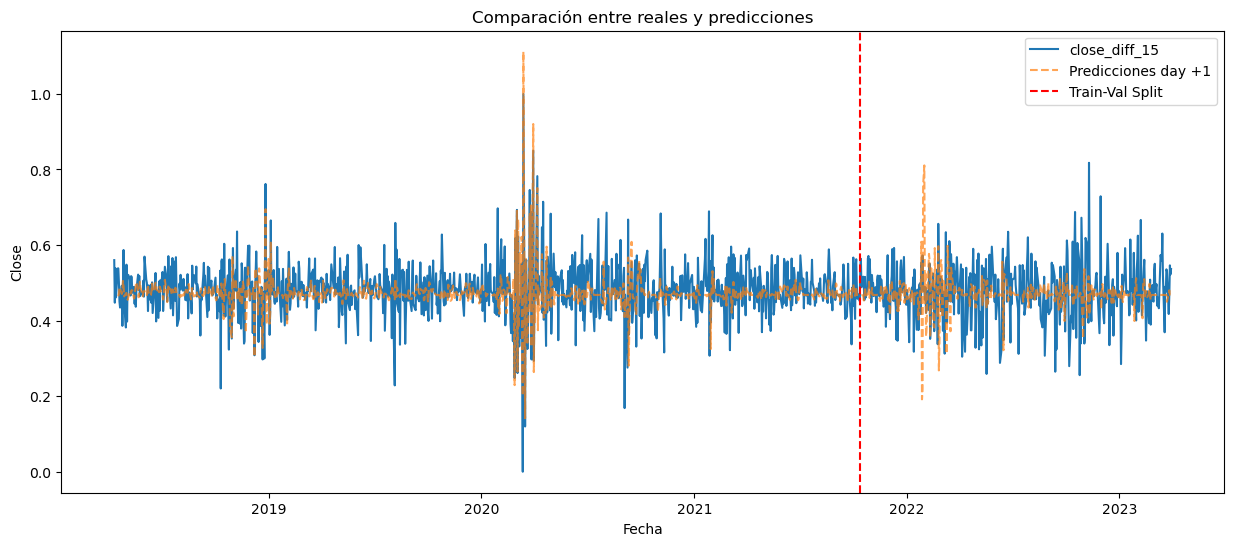

In [713]:

plt.figure(figsize=(15, 6))
plt.plot(df_scaled_Predicciones.index, df_scaled_Predicciones['close_diff_15'], label='close_diff_15')
plt.plot(df_scaled_Predicciones.index,df_scaled_Predicciones['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre reales y predicciones')
plt.legend()
plt.show()

Zoom en validación

In [714]:
timestamp_at_num_train_samples

Timestamp('2021-10-13 00:00:00')

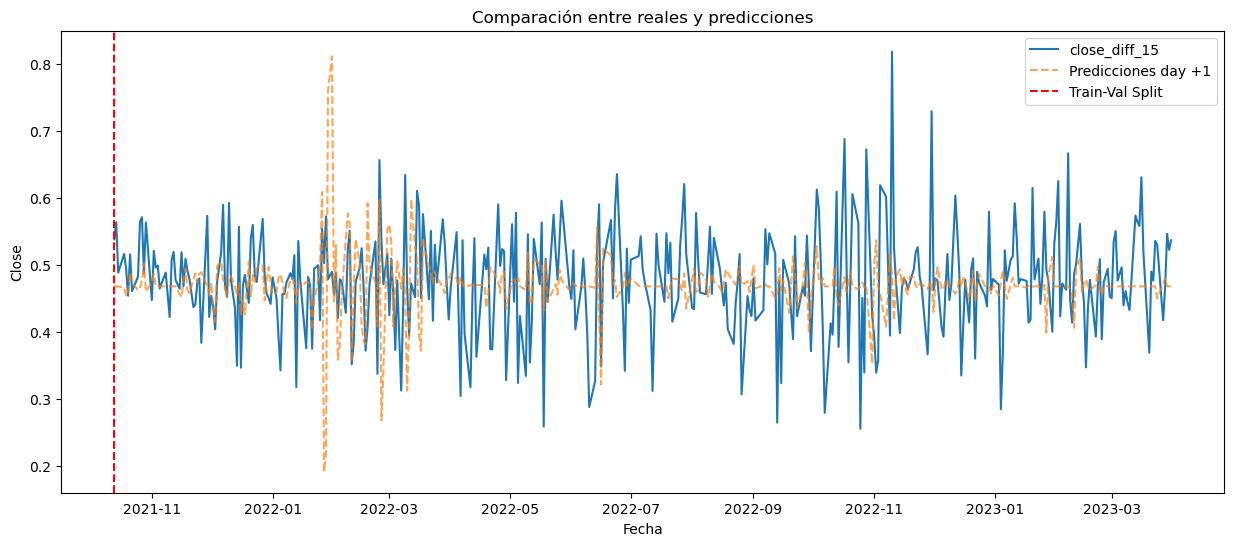

In [715]:
df_scaled_Predicciones_val = df_scaled_Predicciones[df_scaled_Predicciones.index >= timestamp_at_num_train_samples]

plt.figure(figsize=(15, 6))
plt.plot(df_scaled_Predicciones_val.index, df_scaled_Predicciones_val['close_diff_15'], label='close_diff_15')
plt.plot(df_scaled_Predicciones_val.index,df_scaled_Predicciones_val['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre reales y predicciones')
plt.legend()
plt.show()

Lo mismo llevando los datos a la escala original

In [716]:

original_values = scaler.inverse_transform(df_scaled)
df_original = pd.DataFrame(original_values, columns=df_daily_final.columns, index=df_daily_final.index)


df_original['predictions'] = np.nan

df_original.loc[df_original.index[sequence_length:], 'predictions'] = predictions



df_original['predictions'] = df_original['predictions'] * C_range + C_min


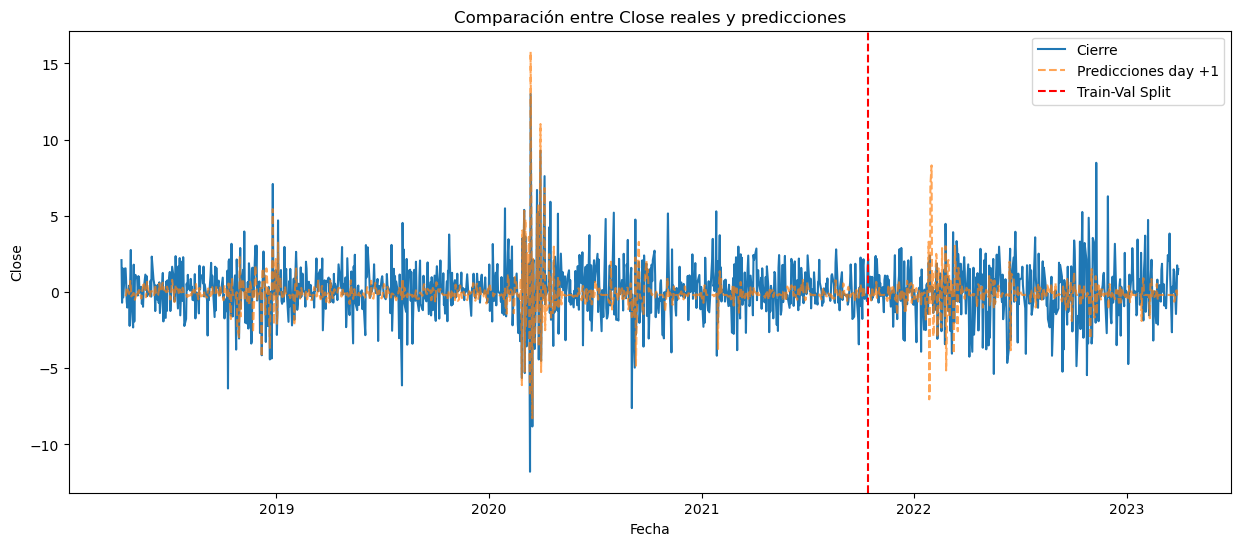

In [717]:
plt.figure(figsize=(15, 6))
plt.plot(df_original.index, df_original['close_diff_15'], label='Cierre')
plt.plot(df_original.index,df_original['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre Close reales y predicciones')
plt.legend()
plt.show()

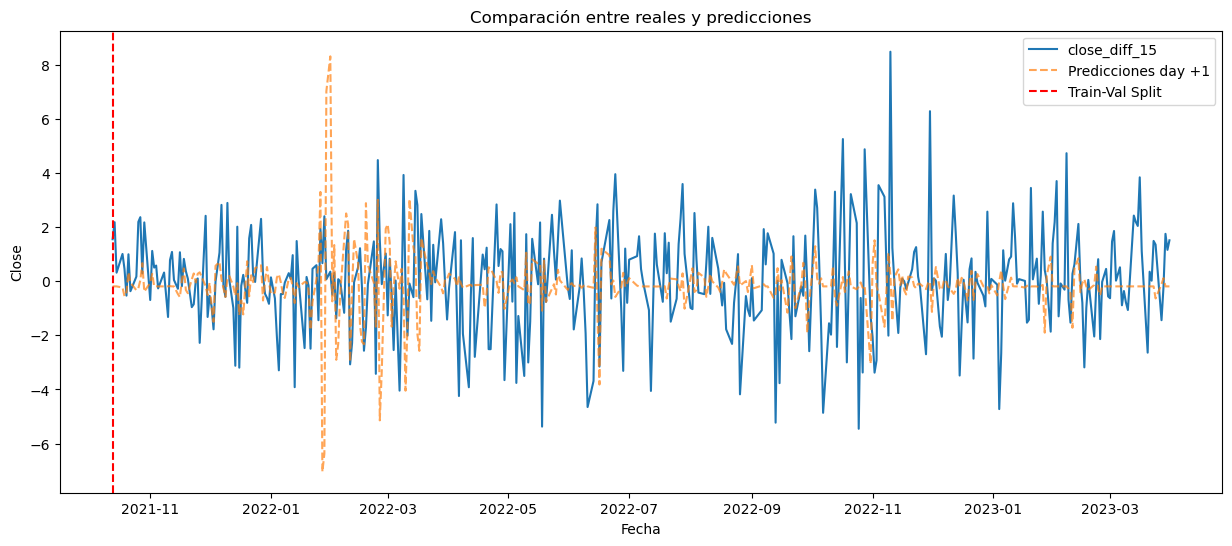

In [718]:
df_original_val = df_original[df_original.index >= timestamp_at_num_train_samples]

plt.figure(figsize=(15, 6))
plt.plot(df_original_val.index, df_original_val['close_diff_15'], label='close_diff_15')
plt.plot(df_original_val.index,df_original_val['predictions'], label='Predicciones day +1', linestyle='--', alpha=0.7)
plt.axvline(x=timestamp_at_num_train_samples, color='r', label='Train-Val Split',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.title('Comparación entre reales y predicciones')
plt.legend()
plt.show()